# FashionMNIST Tiny VGG CNN Solution

In [40]:
from rich.traceback import install
install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x105606b00>>

In [2]:
import torch

In [26]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

## 0. Import all essentials

In [4]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib
import matplotlib.pyplot as plt 

# Import numpy
import numpy as np 

# import pandas
import pandas as pd

print(f"PyTorch Version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")


PyTorch Version: 2.5.1
torchvision version: 0.20.1


## 1. Getting a dataset

PyTorch has a bunch of common computer vision datasets stored in `torchvision.datasets`.

Including FashionMNIST in `torchvision.datasets.FashionMNIST()`.

To download it, we provide the following parameters:

* `root: str` - which folder do you want to download the data to?
* `train: Bool` - do you want the training or test split?
* `download: Bool` - should the data be downloaded?
* `transform: torchvision.transforms` - what transformations would you like to do on the data?
* `target_transform` - you can transform the targets (labels) if you like too.


In [6]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # Where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well 
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [7]:
# Let's check sample
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [8]:
img, label = train_data[0]
img, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [9]:
img.shape

torch.Size([1, 28, 28])

In [10]:
print(f"image shape: {img.shape} -> [colour_channels,height,width]")

image shape: torch.Size([1, 28, 28]) -> [colour_channels,height,width]


In [11]:
len(train_data), len(test_data)

(60000, 10000)

In [12]:
# Set classes
class_names = train_data.classes
class_names, len(class_names)

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 10)

## 1.2 Visualizing our data 

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot')

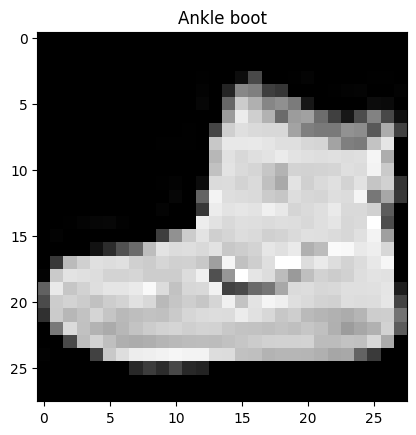

In [13]:
img, label = train_data[0]
print(f"Image shape: {img.shape}")
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])

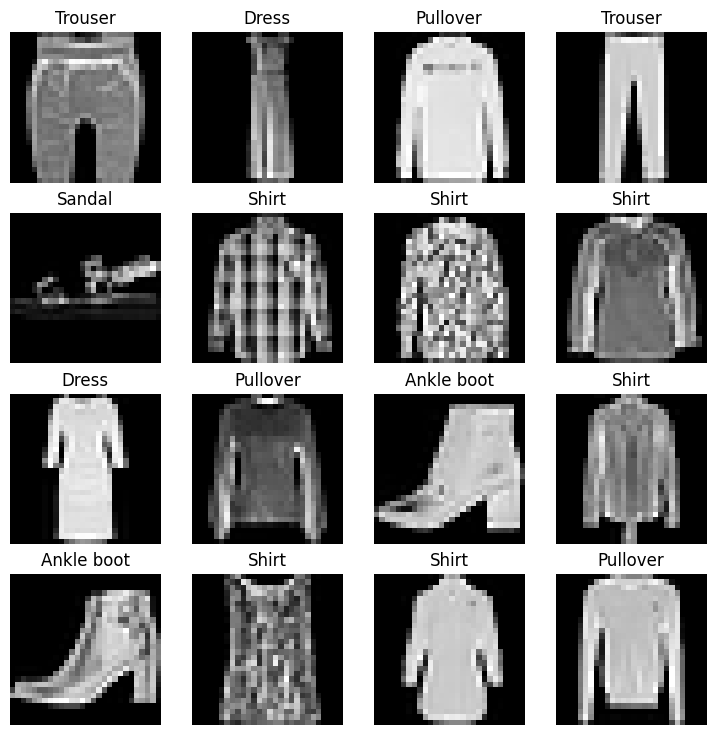

In [14]:
# Plot more images
plt.figure(figsize=(9,9))
nrows, ncols = 4,4
for i in range(1,nrows*ncols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    plt.subplot(nrows, ncols, i)
    img, label = train_data[random_idx]
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## 2. Prepare DataLoader
Now we've got a dataset ready to go.

The next step is to prepare it with a `torch.utils.data.DataLoader` or `DataLoader` for short.

The `DataLoader` does what you think it might do.

It helps load data into a model.

For training and inference. It turns a large `Datasets` into a python iterbale of smaller chunks. These smaller chunks are called **batches** or **mini-batches** and can be set by the `batch_size` parameter. 

Why do this?

Because it is more computationally efficient. With **mini-bacthes**, gradient descent is performed more often per epcoh (once per mini-batch rather than once per epoch). 

In [15]:
from torch.utils.data import DataLoader

# Setup Batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              shuffle=True # Shuffle data every epoch?
                              )

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False) # No need to shuffle because model doesn't know test data while training. 

In [16]:
# Let's check out what we've created. 
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x3092f9c90>, <torch.utils.data.dataloader.DataLoader object at 0x308e78760>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [17]:
# Check what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [18]:
len(train_features_batch)

32

Image shape: torch.Size([1, 28, 28])
Label: 7, label size: torch.Size([])


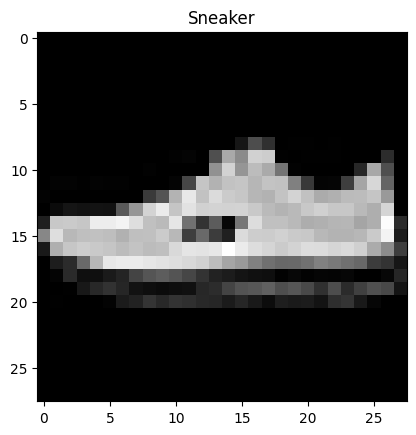

In [19]:
# Show a sample from dataloader

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
print(f"Image shape: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Building a Convolutional Neural Network (CNN)
**** 

CNN's are known for their capabilities to find patterns in visual data and since we are dealing with visual data, let's see if using CNN model gives us a promising result. 

The CNN model we're going to be using is know as TinyVGG from the `CNN Explainer` website. It follows the typical structure of a convolutional neural network. 

`Input Layer -> [Convolutional Layer -> Activation Layer -> Pooling layer] -> Output layer`

In [28]:
# Create a convolutional model
class FashionMNISTModel_check(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape:int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        print(f"shape after going through 1st block: {x.shape}")
        x = self.block_2(x)
        print(f"Shape after going through block 2: {x.shape} ")
        x = self.classifier(x)
        print(f"Shape after going through classifier: {x.shape}")



In [47]:
model_1 = FashionMNISTModel_check(input_shape=1,
                                  hidden_units=10,
                                  output_shape=len(class_names)).to(device)

In [22]:
img.shape

torch.Size([1, 28, 28])

In [23]:
random_tensor = torch.randn(size = (1,28,28))
random_tensor

tensor([[[-1.2042e+00,  1.0917e+00,  7.0961e-01, -1.1020e+00, -1.0054e+00,
          -1.6095e+00,  2.1149e-01, -3.4850e-02,  2.6901e-01, -2.1984e+00,
           6.2861e-01,  3.9305e-01,  1.2147e+00,  9.4254e-01,  1.5979e+00,
           1.1927e+00,  8.3841e-01,  1.0952e+00, -5.0094e-01,  1.9054e+00,
           1.1201e+00,  3.5328e-01, -1.2284e+00,  8.3659e-01, -2.1375e+00,
           1.2819e+00,  2.3546e+00,  6.2556e-01],
         [ 4.8555e-01, -5.4654e-01, -1.1101e+00,  5.4393e-01, -4.4371e-01,
          -8.8404e-01,  1.5399e+00,  1.1705e+00, -1.3223e+00, -1.0742e+00,
          -1.0263e+00, -8.6903e-01,  1.3807e+00, -7.9616e-01,  1.0958e+00,
          -2.4732e-01, -2.8549e-01, -7.3191e-01, -1.1701e-02, -9.9649e-01,
           6.2756e-01, -3.5963e+00, -1.9460e+00,  1.4248e+00,  1.0134e+00,
          -1.1598e+00,  7.1217e-01, -7.9712e-01],
         [-2.8843e-01, -1.2531e+00,  1.9490e-01, -6.8351e-01, -4.6273e-01,
          -1.3243e+00,  1.2700e+00, -4.9207e-01,  1.6312e+00,  1.0726e-01,


In [43]:
random_tensor.shape

torch.Size([1, 28, 28])

In [48]:
model_1(random_tensor.to(device))

shape after going through 1st block: torch.Size([10, 14, 14])
Shape after going through block 2: torch.Size([10, 7, 7]) 


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 model_1(random_tensor.to(device))                                                            │
│   2                                                                                              │
│                                                                                                  │
│ /opt/anaconda3/envs/python_ds/lib/python3.10/site-packages/torch/nn/modules/module.py:1736 in    │
│ _wrapped_call_impl                                                                               │
│                                                                                                  │
│   1733 │   │   if self._compiled_call_impl is not None:                                          │
│   1734 │   │   │   return self._compiled_call_impl(*args, **kwargs)  # type: ignore[misc]        │
│   1735 │   │   else:                                                                             │
│ ❱ 1736 │   │   │   return self._call_impl(*args, **kwargs)                                       │
│   1737 │                                                                                         │
│   1738 │   # torchrec tests the code consistency with the following code                         │
│   1739 │   # fmt: off                                                                            │
│                                                                                                  │
│ /opt/anaconda3/envs/python_ds/lib/python3.10/site-packages/torch/nn/modules/module.py:1747 in    │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1744 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1745 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1746 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1747 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1748 │   │                                                                                     │
│   1749 │   │   result = None                                                                     │
│   1750 │   │   called_always_called_hooks = set()                                                │
│                                                                                                  │
│ in forward:47                                                                                    │
│                                                                                                  │
│   44 │   │   print(f"shape after going through 1st block: {x.shape}")                            │
│   45 │   │   x = self.block_2(x)                                                                 │
│   46 │   │   print(f"Shape after going through block 2: {x.shape} ")                             │
│ ❱ 47 │   │   x = self.classifier(x)                                                              │
│   48 │   │   print(f"Shape after going through classifier: {x.shape}")                           │
│   49                                                                                             │
│   50                                                                                             │
│                                                                                                  │
│ /opt/anaconda3/envs/python_ds/lib/python3.10/site-packages/torch/nn/modules/module.py:1736 in    │
│ _wrapped_call_impl                                         

In [49]:
# Create a convolutional model
class FashionMNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape:int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        print(f"shape after going through 1st block: {x.shape}")
        x = self.block_2(x)
        print(f"Shape after going through block 2: {x.shape} ")
        x = self.classifier(x)
        print(f"Shape after going through classifier: {x.shape}")

